In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import data_cleaner as dc
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
df = pd.read_csv("../clean_data/df_3to1.csv")
df.drop(['ABETA', 'TAU', 'PTAU'], axis=1, inplace=True)

/var/folders/bm/s0j8htzs7tn4d1t__749xglm0000gn/T/ipykernel_42731/2083355638.py:7: DtypeWarning: Columns (16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../clean_data/df_3to1.csv")


In [24]:
### Create lag of DX & Visit
df_prog = df[["RID","DX","VISCODE","ORIGPROT"]]
df_prog = df_prog.sort_values(by=['RID', 'VISCODE']).reset_index() # > ori idx as col 'index'
# add change of DX status & visit:
df_prog['lag_VISCODE'] = df_prog.groupby('RID')['VISCODE'].shift(1)
df_prog['lag_DX'] = df_prog.groupby('RID')['DX'].shift(1) 
df_prog['diff_DX'] = df_prog['DX'] - df_prog['lag_DX']     
df_prog['diff_VISCODE'] = df_prog['VISCODE'] - df_prog['lag_VISCODE']
df_prog.head()

,index,RID,DX,VISCODE,ORIGPROT,lag_VISCODE,lag_DX,diff_DX,diff_VISCODE
0,0,2,1,0,0,NaN,NaN,NaN,NaN
1,4403,2,1,6,0,0.0,1.0,0.0,6.0
2,4404,2,1,36,0,6.0,1.0,0.0,30.0
3,4405,2,1,60,0,36.0,1.0,0.0,24.0
4,7830,2,1,72,0,60.0,1.0,0.0,12.0


In [25]:
### time points move from 2 to 3 will be keep with priority due to data imbalance
df_2to3 = df_prog.loc[(df_prog['diff_VISCODE']==12) & # previous point is t-12
            (df_prog['diff_DX']==1) & # progress=1
            (df_prog['DX']==3)        # currently at stage 3
           ]
df_2to3["RID"].is_unique           # not unique
# df_2to3.loc[df_2to3["RID"]==135] # because some have 'reversed' diagnosis
early_idx = df_2to3.groupby('RID')['VISCODE'].idxmin()
# > keep the one in earlier timepoint, because should have more info
idx_2_to_3 = pd.concat([early_idx, (early_idx-1)], axis=0)  # idx of time 0 & time 12mth
df_2to3 = df_prog.loc[idx_2_to_3].sort_values(by=['RID', 'VISCODE'])
print(df_2to3.shape)
df_2to3.head()

(374, 9)


,index,RID,DX,VISCODE,ORIGPROT,lag_VISCODE,lag_DX,diff_DX,diff_VISCODE
267,7791,61,2,84,0,72.0,1.0,1.0,12.0
268,7790,61,3,96,0,84.0,2.0,1.0,12.0
350,4501,80,2,36,0,24.0,2.0,0.0,12.0
351,4502,80,3,48,0,36.0,2.0,1.0,12.0
437,4515,98,2,24,0,12.0,2.0,0.0,12.0


In [26]:
### keep data that are MCI at baseline but rm if exist in above group
mci_bl = df_prog.loc[(df_prog["VISCODE"]==0) & (df_prog["DX"]==2)]                             # MCI at baseline
mci_after_12 = df_prog.loc[((df_prog["RID"].isin(mci_bl.RID)) & (df_prog["VISCODE"]==12))] # MCI at baseline after 12 mo
df_2atbl = pd.concat([mci_bl, mci_after_12])
df_2atbl = df_2atbl.loc[~df_2atbl["RID"].isin(df_2to3["RID"])] # rm RID in gp 2 to 3
print(df_2atbl.shape)
df_2atbl.head()

(1698, 9)


,index,RID,DX,VISCODE,ORIGPROT,lag_VISCODE,lag_DX,diff_DX,diff_VISCODE
14,5,4,2,0,0,NaN,NaN,NaN,NaN
24,15,6,2,0,0,NaN,NaN,NaN,NaN
97,4422,30,2,0,0,NaN,NaN,NaN,NaN
116,4428,33,2,0,0,NaN,NaN,NaN,NaN
128,61,38,2,0,0,NaN,NaN,NaN,NaN


In [27]:
### keep data move from 2 to 2 in 12 month, but rm if exist in above 2 groups
df_2to2 = df_prog.loc[(df_prog["DX"]==2) &             # DX status=MCI
                      (df_prog['diff_VISCODE']==12) &   
                      (df_prog["diff_DX"]==0)          # previouis status=2
           ]
df_2to2.RID.is_unique   # all unique
early_idx = df_2to2.groupby('RID')['VISCODE'].idxmin() 
idx_2_to_2 = pd.concat([early_idx, (early_idx-1)], axis=0)
df_2to2 = df_prog.loc[idx_2_to_2].sort_values(by=['RID', 'VISCODE'])
df_2to2 = df_2to2.loc[~df_2to2["RID"].isin(df_2to3["RID"])]
df_2to2 = df_2to2.loc[~df_2to2["RID"].isin(df_2atbl["RID"])]
print(df_2to2.shape)
df_2to2.head(5)

(104, 9)


,index,RID,DX,VISCODE,ORIGPROT,lag_VISCODE,lag_DX,diff_DX,diff_VISCODE
8,7880,2,2,132,0,120.0,1.0,1.0,12.0
9,7881,2,2,144,0,132.0,2.0,0.0,12.0
209,7809,55,2,72,0,48.0,2.0,0.0,24.0
210,7808,55,2,84,0,72.0,2.0,0.0,12.0
224,9624,56,2,144,0,120.0,1.0,1.0,24.0


In [28]:
### Combine all groups:
def keep_1st_tp(df):
    idx = df.groupby('RID')['VISCODE'].idxmin()
    return df.loc[idx]
# keep only the rows at baseline:
df_2to3 = keep_1st_tp(df_2to3)
df_2to2 = keep_1st_tp(df_2to2)
df_2atbl = keep_1st_tp(df_2atbl)
# filter from df3to1:
keep_idx = pd.concat([df_2to3["index"], df_2to2["index"], df_2atbl["index"] ])
df_mci = df.iloc[keep_idx]
# set outcome:
df_2to3["progress"] = 1
df_2to2["progress"] = 0
df_2atbl["progress"] = 0
df_outcome = pd.concat([df_2to3, df_2to2, df_2atbl])[["RID", "progress"]]
df_mci = pd.merge(df_mci, df_outcome, on="RID")

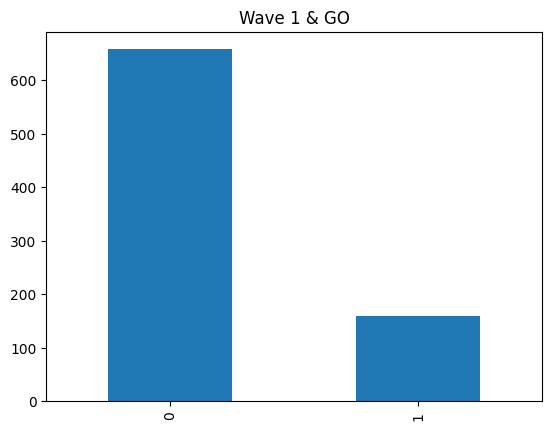

<AxesSubplot: title={'center': 'Wave 2 & 3'}>

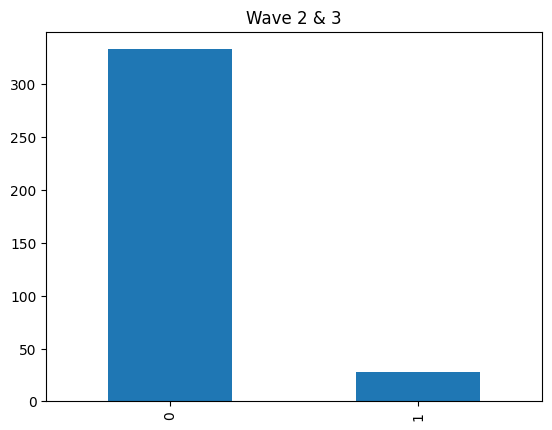

In [29]:
mci_wv1go = df_mci.loc[df_mci.ORIGPROT.isin([0,1])].reset_index(drop=True)
mci_wv23 = df_mci.loc[df_mci.ORIGPROT.isin([2,3])].reset_index(drop=True)
mci_wv1go.progress.value_counts().plot(kind='bar', title='Wave 1 & GO')
plt.show()
mci_wv23.progress.value_counts().plot(kind='bar', title='Wave 2 & 3')


In [30]:
wv1go_view = dc.overview(mci_wv1go) # use 65% as threshold for NaN %
keep_col = wv1go_view.index[wv1go_view.NaN_percentage < 0.65] 
wv1go_view

size: (816, 89)


,dtype,NaN_percentage,unique
FBB,float64,1.0,[nan]
PIB,float64,0.968137,"[nan, 1.2325, 1.215, 1.85, 1.8425, 2.44, 2.115..."
CHEST,float64,0.921569,"[nan, 0.0, 1.0]"
DIARRH,float64,0.921569,"[nan, 0.0, 1.0]"
DIZZY,float64,0.921569,"[nan, 1.0, 0.0]"
SWEATN,float64,0.921569,"[nan, 1.0, 0.0]"
ABDOMN,float64,0.921569,"[nan, 0.0, 1.0]"
CONSTP,float64,0.921569,"[nan, 0.0, 1.0]"
VOMIT,float64,0.921569,"[nan, 0.0, 1.0]"
URNDIS,float64,0.921569,"[nan, 0.0, 1.0]"


In [31]:
mci_wv1go = mci_wv1go[keep_col]
mci_wv23 = mci_wv23[keep_col]

In [32]:
dc.overview(mci_wv23)
# should remove: 'LDELTOTAL_BL', 'DIGITSCOR', 'DX', 'ORIGPROT'

size: (361, 59)


,dtype,NaN_percentage,unique
DIGITSCOR,float64,1.0,[nan]
FLDSTRENG,float64,0.711911,"[nan, 1.0]"
TAU_UPENN,float64,0.709141,"[nan, 97.8, 44.8, 69.0, 60.5, 72.6, 30.9, 47.2..."
ABETA_UPENN,float64,0.709141,"[nan, 113.0, 267.0, 270.0, 232.0, 168.0, 228.0..."
PTAU_UPENN,float64,0.709141,"[nan, 29.2, 15.3, 24.0, 23.2, 34.2, 10.2, 17.4..."
AV45,float64,0.476454,"[nan, 1.1882, 1.689, 1.5094, 1.6112, 0.9692, 1..."
FDG,float64,0.290859,"[nan, 1.22913, 1.05883, 0.922279, 1.17907, 1.2..."
APOE4,float64,0.221607,"[0.0, 1.0, 2.0, nan]"
MidTemp,float64,0.185596,"[nan, 22045.0, 20784.0, 17116.0, 19461.0, 1946..."
Fusiform,float64,0.185596,"[nan, 22341.0, 20642.0, 18380.0, 16977.0, 1307..."


In [33]:
mci_wv1go.drop(['RID','LDELTOTAL_BL', 'DIGITSCOR', 'DX', 'ORIGPROT'], axis=1, inplace=True)
mci_wv23.drop(['RID', 'LDELTOTAL_BL', 'DIGITSCOR', 'DX', 'ORIGPROT'], axis=1, inplace=True)

In [34]:
def binary_to_int(df):
    """
    TODO: turn binary variable to integer
    """
    int_col = df.columns[df.apply(lambda x:len(x.dropna().unique()))==2].to_list() # find unique val=2 not including NaN
    df.loc[:,int_col] = df.loc[:,int_col].astype('Int64')
    return df
mci_wv23 = binary_to_int(mci_wv23)
mci_wv1go = binary_to_int(mci_wv1go)

/var/folders/bm/s0j8htzs7tn4d1t__749xglm0000gn/T/ipykernel_42731/950207978.py:6: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:,int_col] = df.loc[:,int_col].astype('Int64')
/var/folders/bm/s0j8htzs7tn4d1t__749xglm0000gn/T/ipykernel_42731/950207978.py:6: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:,int_col] = df.loc[:,int_col].astype('Int64')


In [35]:
mci_wv1go.to_csv('../clean_data/mci_wv1go_aug.csv', index=False)
mci_wv23.to_csv('../clean_data/mci_wv23_aug.csv', index=False)